# Bicluster-metadata association (Demo Notebook)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Simulate Input Data (toy example)
Sample size: 50

In [2]:
np.random.seed(42)
n_samples = 50
sample_ids = [f"S{i+1}" for i in range(n_samples)]

metadata_vars = ["grossinf","microinf","hs","arteriol","atheroscler",
                 "late","lewy_body","caa","braak","cerad","diffuse_abeta"]

binary_vars = ["grossinf","microinf","hs","arteriol","atheroscler","lewy_body","caa","diffuse_abeta"]
ordinal_vars = ["late","braak","cerad"]

metadata = pd.DataFrame({"sample_name": sample_ids})

# Random metadata values
for var in binary_vars:
    metadata[var] = np.random.choice([0,1], size=n_samples, p=[0.6,0.4])
for var in ordinal_vars:
    metadata[var] = np.random.choice([0,1,2,3], size=n_samples, p=[0.2,0.3,0.3,0.2])
    
metadata.head(3)

,sample_name,grossinf,microinf,hs,arteriol,atheroscler,lewy_body,caa,diffuse_abeta,late,braak,cerad
0,S1,0,1,0,1,1,0,0,0,0,2,2
1,S2,1,1,1,0,0,0,0,1,3,2,2
2,S3,1,1,0,0,0,1,0,1,2,1,1


### Create biclusters 
 * 10 biclusters, random subsets of samples
 * make bicluster BC3 enriched for grossinf=1
 * make BC5 enriched for late=3

In [3]:
biclusters = []
for bic_id in range(1, 11):
    cluster_size = np.random.randint(5, 20)
    chosen_samples = np.random.choice(sample_ids, size=cluster_size, replace=False)
    biclusters.append({"id": f"BC{bic_id}", "samples": " ".join(chosen_samples)})

biclusters = pd.DataFrame(biclusters)

# Inject signals for demonstration
# Make BC3 enriched for grossinf=1
bc3_samples = biclusters.loc[biclusters["id"]=="BC3","samples"].iloc[0].split()
metadata.loc[metadata["sample_name"].isin(bc3_samples), "grossinf"] = 1

# Make BC5 enriched for late=3
bc5_samples = biclusters.loc[biclusters["id"]=="BC5","samples"].iloc[0].split()
metadata.loc[metadata["sample_name"].isin(bc5_samples), "late"] = 3

# Save files (optional, to mimic your workflow)
metadata.to_csv("pheno_np_filt.csv", index=False)
biclusters.to_csv("biclusters.tsv", sep="\t", index=False)
print("Simulated metadata and biclusters created.")
# format biclusters 
biclusters = biclusters.set_index("id",drop=True)
biclusters["samples"] = biclusters["samples"].apply(lambda x: set(x.split(" ")))
display(metadata.head())
display(biclusters.head())

Simulated metadata and biclusters created.


,sample_name,grossinf,microinf,hs,arteriol,atheroscler,lewy_body,caa,diffuse_abeta,late,braak,cerad
0,S1,0,1,0,1,1,0,0,0,0,2,2
1,S2,1,1,1,0,0,0,0,1,3,2,2
2,S3,1,1,0,0,0,1,0,1,2,1,1
3,S4,1,1,0,0,1,0,1,0,3,3,3
4,S5,0,0,1,1,1,0,1,0,1,0,2


,samples
id,
BC1,"{S38, S28, S16, S36, S49, S9, S26, S7, S39, S3..."
BC2,"{S35, S44, S43, S17, S39, S7, S14, S50, S34, S..."
BC3,"{S38, S12, S21, S16, S49, S29, S27, S31, S39, ..."
BC4,"{S38, S35, S10, S29, S7, S14, S45, S20}"
BC5,"{S25, S16, S36, S41, S29, S22, S7, S31, S30, S..."


### 2. Enrichment Analysis

* test binary and ordinal variables for association with each bicluster

In [4]:
results = []
for bic_id, row in biclusters.iterrows():
    sample_ids = row["samples"]

    in_cluster = metadata[metadata["sample_name"].isin(sample_ids)]
    out_cluster = metadata[~metadata["sample_name"].isin(sample_ids)]

    for var in metadata_vars:
        values_in = in_cluster[var].dropna()
        values_out = out_cluster[var].dropna()
        if values_in.empty or values_out.empty:
            continue

        unique_vals = metadata[var].dropna().unique()
        pval = np.nan
        enriched_info = None
        dominant_category = None
        samples_by_category = None

        if len(unique_vals) <= 2:  # binary variable
            in_pos = int((values_in==1).sum())
            in_neg = int((values_in==0).sum())
            out_pos = int((values_out==1).sum())
            out_neg = int((values_out==0).sum())
            table = [[in_pos, in_neg],[out_pos, out_neg]]
            try:
                oddsratio, pval = fisher_exact(table)
            except Exception:
                pval = np.nan

            enriched_info = f"0:{in_neg}, 1:{in_pos}"
            dominant_category = 0 if in_neg > in_pos else 1 if in_pos > in_neg else None

            samples_by_category_dict = {
                str(cat): list(in_cluster.loc[values_in[values_in==cat].index, "sample_name"])
                for cat in [0,1]
            }
            samples_by_category = "\n".join([f"{cat}: {','.join(samps)}"
                                             for cat, samps in samples_by_category_dict.items()])
        else:  # ordinal variable
            try:
                stat, pval = mannwhitneyu(values_in, values_out, alternative="two-sided")
            except Exception:
                pval = np.nan

            counts = values_in.value_counts().sort_index()
            enriched_info = ", ".join([f"{cat}:{count}" for cat, count in counts.items()])
            dominant_category = int(counts.idxmax()) if not counts.empty else None

            samples_by_category_dict = {
                str(cat): list(in_cluster.loc[values_in[values_in==cat].index, "sample_name"])
                for cat in counts.index
            }
            samples_by_category = "\n".join([f"{cat}: {','.join(samps)}"
                                             for cat, samps in samples_by_category_dict.items()])

        results.append({
            "bicluster_id": bic_id,
            "metadata_var": var,
            "n_samples_in": len(values_in),
            "n_samples_out": len(values_out),
            "pval": pval,
            "category_counts_in_cluster": enriched_info,
            "dominant_category_in_cluster": dominant_category,
            "samples_by_category_in_cluster": samples_by_category
        })

results_df = pd.DataFrame(results)
pvals = results_df["pval"].fillna(1.0).astype(float).values
results_df["fdr"] = multipletests(pvals, method="fdr_bh")[1]

# Save results
results_df.to_csv("bicluster_metadata_associations.tsv", sep="\t", index=False)

print("\nResults:")
display(results_df.head(10))


Results:


,bicluster_id,metadata_var,n_samples_in,n_samples_out,pval,category_counts_in_cluster,dominant_category_in_cluster,samples_by_category_in_cluster,fdr
0,BC1,grossinf,15,35,0.216534,"0:5, 1:10",1.0,"0: S7,S24,S28,S33,S42\n1: S3,S9,S13,S16,S26,S3...",0.917699
1,BC1,microinf,15,35,0.355733,"0:7, 1:8",1.0,"0: S7,S9,S16,S28,S33,S36,S49\n1: S3,S13,S24,S2...",0.964301
2,BC1,hs,15,35,0.523092,"0:11, 1:4",0.0,"0: S3,S7,S9,S24,S26,S32,S33,S36,S39,S42,S49\n1...",0.964301
3,BC1,arteriol,15,35,1.000000,"0:8, 1:7",0.0,"0: S3,S9,S24,S26,S28,S32,S38,S39\n1: S7,S13,S1...",1.000000
4,BC1,atheroscler,15,35,0.224250,"0:10, 1:5",0.0,"0: S3,S7,S9,S16,S24,S26,S28,S32,S33,S38\n1: S1...",0.917699
5,BC1,late,15,35,0.167174,"1:2, 2:5, 3:8",3.0,"1: S24,S49\n2: S3,S26,S32,S33,S39\n3: S7,S9,S1...",0.917699
6,BC1,lewy_body,15,35,1.000000,"0:9, 1:6",0.0,"0: S9,S13,S26,S32,S33,S36,S38,S39,S42\n1: S3,S...",1.000000
7,BC1,caa,15,35,0.754428,"0:9, 1:6",0.0,"0: S3,S7,S13,S24,S33,S36,S39,S42,S49\n1: S9,S1...",1.000000
8,BC1,braak,15,35,0.369727,"0:2, 1:4, 2:4, 3:5",3.0,"0: S7,S9\n1: S3,S16,S33,S38\n2: S13,S28,S32,S4...",0.964301
9,BC1,cerad,15,35,0.543515,"0:1, 1:5, 2:2, 3:7",3.0,"0: S16\n1: S3,S26,S28,S38,S39\n2: S42,S49\n3: ...",0.964301


### 3. Heatmap Visualization

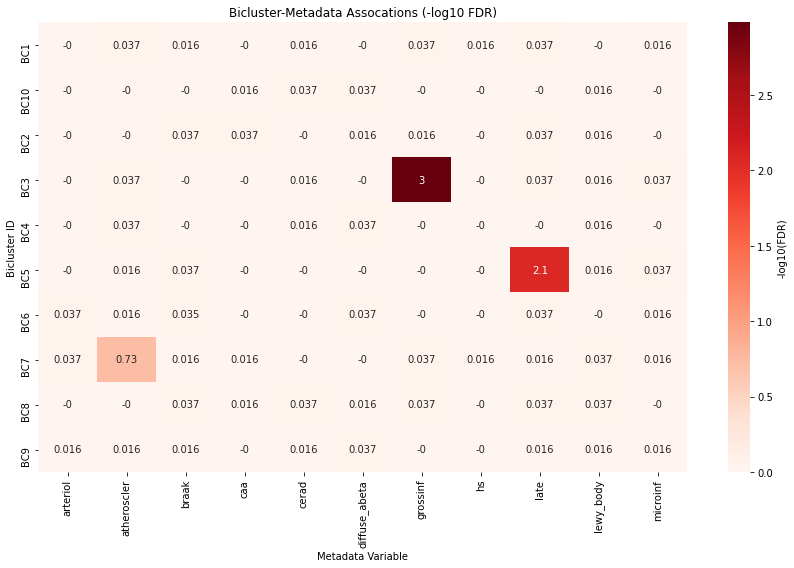

In [5]:
heatmap_data = results_df.pivot(index="bicluster_id", columns="metadata_var", values="fdr")
heatmap_plot = (-np.log10(heatmap_data.replace({0: np.nan}))).fillna(0)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_plot, annot=True, cmap="Reds", cbar_kws={'label':'-log10(FDR)'})
plt.title("Bicluster-Metadata Assocations (-log10 FDR)")
plt.xlabel("Metadata Variable")
plt.ylabel("Bicluster ID")
plt.tight_layout()
plt.show()

### 4. Significant Associations with Improved Heatmap


Significant associations (FDR < 0.05): 2 found


,bicluster_id,metadata_var,n_samples_in,n_samples_out,pval,category_counts_in_cluster,dominant_category_in_cluster,samples_by_category_in_cluster,fdr
22,BC3,grossinf,14,36,0.000010,"0:0, 1:14",1.0,"0: \n1: S4,S9,S12,S16,S21,S27,S29,S31,S32,S38,...",0.001046
49,BC5,late,12,38,0.000158,3:12,3.0,"3: S7,S15,S16,S22,S25,S29,S30,S31,S36,S40,S41,S48",0.008684


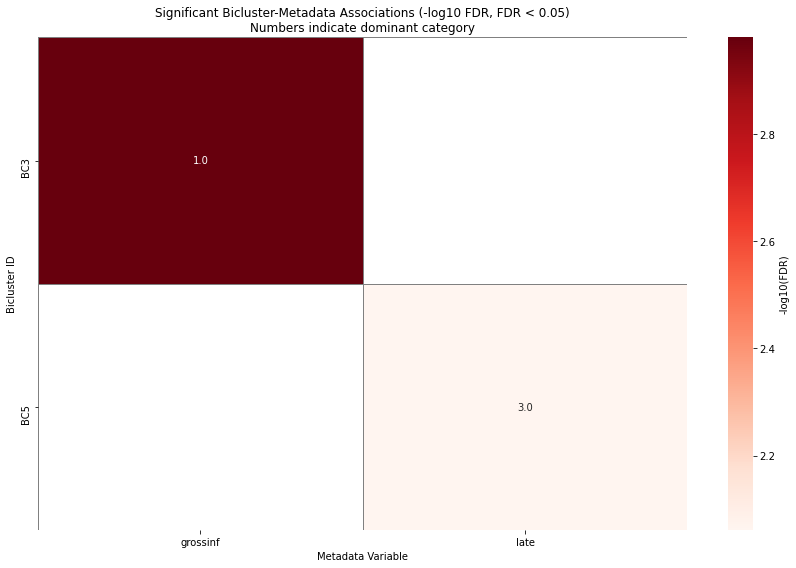

In [6]:
# Filter significant associations
sig = results_df[results_df["fdr"] < 0.05].sort_values("fdr")
print(f"\nSignificant associations (FDR < 0.05): {len(sig)} found")
display(sig)

if not sig.empty:
    # Pivot for heatmap
    sig_heatmap_data = sig.pivot(index="bicluster_id", columns="metadata_var", values="fdr")

    # Transform FDR to -log10(FDR) and cap at 5
    sig_heatmap_plot = -np.log10(sig_heatmap_data)
    sig_heatmap_plot = sig_heatmap_plot.clip(upper=5)  # cap for readability

    # Overlay dominant category inside each cell
    dominant_data = sig.pivot(index="bicluster_id", columns="metadata_var", values="dominant_category_in_cluster")

    plt.figure(figsize=(12,8))
    sns.heatmap(sig_heatmap_plot, annot=dominant_data, fmt="", cmap="Reds",
                cbar_kws={'label':'-log10(FDR)'}, linewidths=0.5, linecolor='gray')
    plt.title("Significant Bicluster-Metadata Associations (-log10 FDR, FDR < 0.05)\nNumbers indicate dominant category")
    plt.xlabel("Metadata Variable")
    plt.ylabel("Bicluster ID")
    plt.tight_layout()
    plt.show()
else:
    print("No significant associations found for FDR < 0.05.")